<a href="https://colab.research.google.com/github/Valgueiro/dataScience_project/blob/master/Projeto_2_dataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisandos os dados da temporada 2019/20 da NFL

Utilizarei os dados de https://www.kaggle.com/dvc415/nfl-2019-weekly-player-stats . Nele podemos encontrar estatísticas sobre diversos jogadores de 3 posiçoes do futebol americano:

* Quaterbacks (qbs) - A mente por trás do ataque, são os responsáveis por liderar e coordenar o ataque

* Running Backs (rbs) - corredores da equipe, geralmente recebem a bola diretamente do Quarteback e correm para dentro da defesa.

* Wide receivers (wrs) - também são corredores, mas geralmente correm pra dentro da defesa adversária e recebem a bola do QB através de um passe.

## Pré-processando os dados

### Coletando dados



In [232]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [233]:
qbs = pd.read_csv("https://raw.githubusercontent.com/Valgueiro/dataScience_project/master/data/nfl_2019_qb_weekly_stats.csv")

### Filtrando e reorganizando os dados de Qbs

In [234]:
qbs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rank           611 non-null    int64  
 1   Player         611 non-null    object 
 2   Position       611 non-null    object 
 3   Age            611 non-null    float64
 4   Date           611 non-null    object 
 5   League         611 non-null    object 
 6   Team           611 non-null    object 
 7   Opp            611 non-null    object 
 8   Result         611 non-null    object 
 9   Game           611 non-null    int64  
 10  Week           611 non-null    int64  
 11  Day            611 non-null    object 
 12  Cmp            611 non-null    int64  
 13  Pass_Att       611 non-null    int64  
 14  Cmp_Per        611 non-null    float64
 15  Pass_Yards     611 non-null    int64  
 16  Pass_TD        611 non-null    int64  
 17  Pass_Int       611 non-null    int64  
 18  QB_Rate   

Logo de cara podemos ver que não temos dados ausentes, mas alguns tipos devem ser estudados e melhorados, assim como algumas colunas devem ser discretizadas.

#### Verificando a necessidade da coluna "Position"

In [235]:
qbs["Position"].unique()

array(['QB', 'WR', 'RB', 'K', 'P', 'FB/TE'], dtype=object)

In [236]:
qbs[qbs["Position"] == 'WR'][["Player", "Pass_Att"]]

,Player,Pass_Att
14,Julian Edelman,1
43,Dante Pettis,1
142,Odell Beckham Jr.,1
146,DeAndre Hopkins,1
151,Odell Beckham Jr.,1
248,Zach Pascal,1
338,Randall Cobb,1
343,Julian Edelman,1
348,Courtland Sutton,1
411,Steven Sims,1


Como podemos ver, o dataset conta também com jogadores de outra posição que jogaram de QB em algum momento, como por exemplo os Wide Receivers que vemos nesta ultima tabela. Com as duas colunas mostradas podemos ver que todos eles fizeram apenas 2 passes no máximo. Geralmente essas jogadas são fora do comum, são chamadas de "trick play".

#### Verificando o tipo da coluna "Age"

In [237]:
qbs["Age"].describe()

count    611.000000
mean      28.154298
std        5.364599
min       22.032000
25%       24.046500
50%       26.308000
75%       31.219000
max       42.148000
Name: Age, dtype: float64

In [238]:
qbs[qbs["Player"] == "Kirk Cousins"][["Player","Age","Date"]]

,Player,Age,Date
4,Kirk Cousins,31.020,2019-09-08
72,Kirk Cousins,31.027,2019-09-15
86,Kirk Cousins,31.034,2019-09-22
126,Kirk Cousins,31.041,2019-09-29
149,Kirk Cousins,31.048,2019-10-06
186,Kirk Cousins,31.055,2019-10-13
219,Kirk Cousins,31.062,2019-10-20
259,Kirk Cousins,31.066,2019-10-24
298,Kirk Cousins,31.076,2019-11-03
318,Kirk Cousins,31.083,2019-11-10


Como podemos ver, apesar de idade normalmente ser tratada com inteiro, aqui é mostrada a idade inclusive incluindo a quantidade de meses e dias.

#### Transformando o tipo da coluna Date

Com o describe, vimos que a coluna Date está com o tipo Object. Devemos mudá-la para o tipo correto de datas.

In [239]:
qbs["Date"].head()

0    2019-09-08
1    2019-09-08
2    2019-09-08
3    2019-09-08
4    2019-09-08
Name: Date, dtype: object

In [240]:
qbs["Date"] = pd.to_datetime(qbs["Date"])
qbs["Date"].head()

0   2019-09-08
1   2019-09-08
2   2019-09-08
3   2019-09-08
4   2019-09-08
Name: Date, dtype: datetime64[ns]

#### Verificando a necessidade da coluna League

In [241]:
qbs["League"].unique()

array(['NFL'], dtype=object)

Como podemos ver todas as linhas tem o mesmo valor para esta coluna. Como já é sabido que estamos no contexto da NFL, vou retirá-la do dataset.

In [242]:
qbs = qbs.drop(columns=['League'])

#### Separar dados da coluna Result

In [243]:
qbs["Result"].head()

0    W 59-10
1    W 35-17
2    W 59-10
3    W 40-26
4    W 28-12
Name: Result, dtype: object

A coluna result contem 3 informaçoes: O resultado final do jogo para o jogador, a quantidade de pontos feitos e a quantidade de pontos recebidos. Vamos separar esses dados em 3 colunas distintas

In [244]:
import re
parsed_results = qbs["Result"].map(lambda result: re.findall('(.+) (\d+)-(\d+)', result)[0])
qbs['Game_result'] = parsed_results.map(lambda parsed: parsed[0])
qbs['Points_scored'] = parsed_results.map(lambda parsed: parsed[1])
qbs['Points_Taken'] = parsed_results.map(lambda parsed: parsed[2])

qbs[['Game_result', 'Points_scored', 'Points_Taken']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Game_result    611 non-null    object
 1   Points_scored  611 non-null    object
 2   Points_Taken   611 non-null    object
dtypes: object(3)
memory usage: 14.4+ KB


Após dividir as informaçoes, vamos mudar o tipo para inteiro e apagar a coluna que foi dividida.

In [245]:
qbs['Points_scored'] = pd.to_numeric(qbs['Points_scored'])
qbs['Points_Taken'] = pd.to_numeric(qbs['Points_Taken'])
qbs[['Game_result', 'Points_scored', 'Points_Taken']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Game_result    611 non-null    object
 1   Points_scored  611 non-null    int64 
 2   Points_Taken   611 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.4+ KB


In [246]:
qbs = qbs.drop(columns=['Result'])

### Resultado final


In [247]:
qbs.head()

,Rank,Player,Position,Age,Date,Team,Opp,Game,Week,Day,Cmp,Pass_Att,Cmp_Per,Pass_Yards,Pass_TD,Pass_Int,QB_Rate,Sacked,Yds_Lost,Yards_Att,Adj_Yards_Att,Game_result,Points_scored,Points_Taken
0,1,Lamar Jackson,QB,22.244,2019-09-08,BAL,MIA,1,1,Sun,17,20,85.00,324,5,0,158.3,1,1,16.20,16.20,W,59,10
1,2,Dak Prescott,QB,26.041,2019-09-08,DAL,NYG,1,1,Sun,25,32,78.13,405,4,0,158.3,0,0,12.66,12.66,W,35,17
2,3,Robert Griffin III,QB,29.208,2019-09-08,BAL,MIA,1,1,Sun,6,6,100.00,55,1,0,144.4,0,0,9.17,9.17,W,59,10
3,4,Patrick Mahomes,QB,23.356,2019-09-08,KAN,JAX,1,1,Sun,25,33,75.76,378,3,0,143.2,0,0,11.45,11.45,W,40,26
4,5,Kirk Cousins,QB,31.020,2019-09-08,MIN,ATL,1,1,Sun,8,10,80.00,98,1,0,140.8,1,1,9.80,9.80,W,28,12


In [248]:
qbs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Rank           611 non-null    int64         
 1   Player         611 non-null    object        
 2   Position       611 non-null    object        
 3   Age            611 non-null    float64       
 4   Date           611 non-null    datetime64[ns]
 5   Team           611 non-null    object        
 6   Opp            611 non-null    object        
 7   Game           611 non-null    int64         
 8   Week           611 non-null    int64         
 9   Day            611 non-null    object        
 10  Cmp            611 non-null    int64         
 11  Pass_Att       611 non-null    int64         
 12  Cmp_Per        611 non-null    float64       
 13  Pass_Yards     611 non-null    int64         
 14  Pass_TD        611 non-null    int64         
 15  Pass_Int       611 non-

## Trabalho de Classificaçao de dados

Agora tentarei montar um classificador para prever se um QB ganhou ou perdeu uma partida de acordo com os seus atributos. 


Antes de tudo, vou remover um único jogo que deu empate na temporada que está sendo estudada pois precisamos de pelo menos 5 exemplos de cada classa para utilizar a validaçao cruzada (cross-validation). Desse jeito, so deve haver vitórias ou derrotas no dataset.


In [249]:
qbs = qbs[qbs["Game_result"] != 'T']
qbs["Game_result"].unique()

array(['W', 'L'], dtype=object)

### Preparaçao dos dados

Primeiramente vamos remover as colunas que dizem os resultados dos jogos e separar os dados entre "entradas" e "saída" esperados.

Sobre a saída, ela deve se basear apenas no status da partida: Se foi W ou L.

Sobre os atributos de entrada, além de retirar os dados de resultado da partida, também vou retirar dados que não devem estar relacionados aos atributos da partida: Rank, Nome, Posição, Times envolvidos na partida, Data e ID do jogo.

In [250]:
results = qbs["Game_result"]

qbs_attributes = qbs.drop(['Game_result', 'Points_scored', 'Points_Taken', 'Rank', 'Player', 'Position', 'Date', 'Team', 'Opp', 'Game'], axis=1)

qbs_attributes

,Age,Week,Day,Cmp,Pass_Att,Cmp_Per,Pass_Yards,Pass_TD,Pass_Int,QB_Rate,Sacked,Yds_Lost,Yards_Att,Adj_Yards_Att
0,22.244,1,Sun,17,20,85.00,324,5,0,158.3,1,1,16.20,16.20
1,26.041,1,Sun,25,32,78.13,405,4,0,158.3,0,0,12.66,12.66
2,29.208,1,Sun,6,6,100.00,55,1,0,144.4,0,0,9.17,9.17
3,23.356,1,Sun,25,33,75.76,378,3,0,143.2,0,0,11.45,11.45
4,31.020,1,Sun,8,10,80.00,98,1,0,140.8,1,1,9.80,9.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,29.320,17,Sun,11,21,52.38,96,0,1,44.9,3,15,4.57,4.57
607,24.151,17,Sun,12,29,41.38,122,0,1,39.7,1,7,4.21,4.21
608,25.187,17,Sun,0,1,0.00,0,0,0,39.6,0,0,0.00,0.00
609,27.248,17,Sun,12,21,57.14,126,0,2,35.1,0,0,6.00,6.00


Também temos que transformar o dia em um número para que os modelos aceitem o seu formato.

In [251]:
qbs_attributes['Day'] = qbs_attributes['Day'].astype('category').cat.codes

Também temos que transformar os resultados em números.


In [252]:
results = results.astype('category').cat.codes

Como iremos utilizar o método de cross validation, não é necessário separaros dados em treinamento, validação e teste pois o próprio algoritmo já faz este trabalho.

### Tunning de Modelos

Agora temos que escolher que modelo utilizaremos para o nosso preditor. 
Os modelos escolhidos para se trabalhar foram:


*   Multi-layer Perceptron
*   k-nearest neighbors
*   Decision Tree
*   Random Forest

Vamos agora passar por cada um para escolher os melhores hiper-parâmetros através do método de cross-validation. Com ela vamos testar o mesmo modelo com multiplos subconjutos mutualmente exclusivos de dados para medir o nível de generalizaçao do mesmo.

#### Multi-layer Perceptron

Vamos agora escolher os melhores valores de **alpha** e **max_iter** para este algoritmo.


Primeiramente vamos analisar a acurácia de alpha entre 0.0001 e 0.001 aumentando em 0.00025.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'Cross-Validated Accuracy')

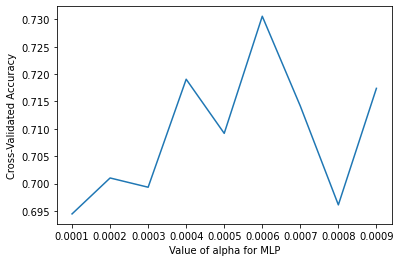

In [253]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy 
alpha_range = numpy.arange(0.0001, 0.001, 0.00010)
alpha_scores = {}
for a in alpha_range:
    model = MLPClassifier(alpha=a)
    scores = cross_val_score(model, qbs_attributes, results, cv=5, scoring='accuracy')
    alpha_scores[a] = scores.mean() 

plt.plot(list(alpha_scores.keys()), list(alpha_scores.values()))
plt.xlabel('Value of alpha for MLP')
plt.ylabel('Cross-Validated Accuracy')

In [265]:
best_alpha = 0
best_accuracy = 0

for index, accuracy in alpha_scores.items():
  if best_accuracy < accuracy:
    best_alpha = index
    best_accuracy = accuracy

print("A melhor acurácia (", best_accuracy*100, "%) foi encontrada com alpha =", best_alpha)

A melhor acurácia ( 73.05785123966942 %) foi encontrada com alpha = 0.0006000000000000001


Agora vamos descobrir um valor bom para max_iter baseado no valor de alpha. Vamos mudar max_iter de 100 até 300 aumentando de 10 em 10.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'Cross-Validated Accuracy')

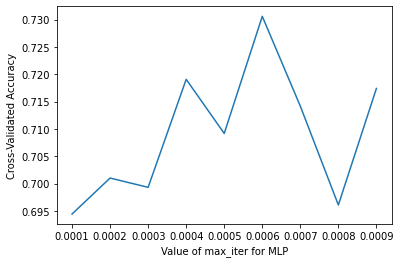

In [255]:
max_iter_range = range(100, 300, 10)
max_iter_scores = {}

for m in max_iter_range:
    model = MLPClassifier(alpha=best_alpha, max_iter=m)
    scores = cross_val_score(model, qbs_attributes, results, cv=5, scoring='accuracy')
    max_iter_scores[m] = scores.mean() 

plt.plot(list(alpha_scores.keys()), list(alpha_scores.values()))
plt.xlabel('Value of max_iter for MLP')
plt.ylabel('Cross-Validated Accuracy')

In [266]:
best_max_iter = 200

for index, accuracy in max_iter_scores.items():
  if best_accuracy < accuracy:
    best_max_iter = index
    best_accuracy = accuracy

print("A melhor acurácia (", best_accuracy*100, "%) foi encontrada com alpha =", best_alpha, " e max_iter = ", best_max_iter)

A melhor acurácia ( 73.05785123966942 %) foi encontrada com alpha = 0.0006000000000000001  e max_iter =  200


#### KNN

Vamos agora escolher o melhor valor de **N_neighbors** para este algoritmo. Vamos analisar a acurácia de valores entre 1 e 30.


Text(0, 0.5, 'Cross-Validated Accuracy')

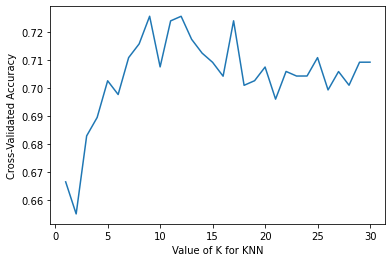

In [257]:
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
k_scores = {}

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, qbs_attributes, results, cv=5, scoring='accuracy')
    k_scores[k] = scores.mean() 

plt.plot(list(k_scores.keys()), list(k_scores.values()))
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Agora vamos procurar qual foi o K que gerou a melhor acurácia.

In [258]:
best_k = 1
best_accuracy = 0

for index, accuracy in k_scores.items():
  if best_accuracy < accuracy:
    best_k = index
    best_accuracy = accuracy

print("A melhor acurácia (", best_accuracy*100, "%) foi encontrada com K =", best_k)

A melhor acurácia ( 72.5660479609809 %) foi encontrada com K = 9


#### Decision Tree

Vamos agora escolher o melhor valor de **max_depth** para este algoritmo. Vamos alternar o max_depth entre os valores de 1 e 30.


Text(0, 0.5, 'Cross-Validated Accuracy')

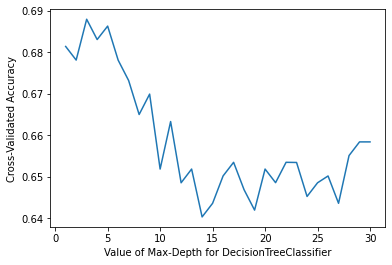

In [259]:
from sklearn.tree import DecisionTreeClassifier

depth_range = range(1,31)
depth_scores = {}

for d in depth_range:
    model = DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(model, qbs_attributes, results, cv=5, scoring='accuracy')
    depth_scores[d] = scores.mean()

plt.plot(list(depth_scores.keys()), list(depth_scores.values()))
plt.xlabel('Value of Max-Depth for DecisionTreeClassifier')
plt.ylabel('Cross-Validated Accuracy')

Agora vamos procurar qual foi a profundidade que gerou a melhor acurácia.

In [260]:
best_depth = 1
best_accuracy = 0

for index, accuracy in depth_scores.items():
  if best_accuracy < accuracy:
    best_depth = index
    best_accuracy = accuracy

print("A melhor acurácia (", best_accuracy*100, "%) foi encontrada com max-depth =", best_depth)

A melhor acurácia ( 68.79555615770221 %) foi encontrada com max-depth = 3


#### Random Forest

Vamos agora escolher o melhor valor de **n_estimators** (o númeor de árvores na floresta) para este algoritmo. Aqui vamos utilizar valores de 10 a 200 aumentando de 10 em 10


Text(0, 0.5, 'Cross-Validated Accuracy')

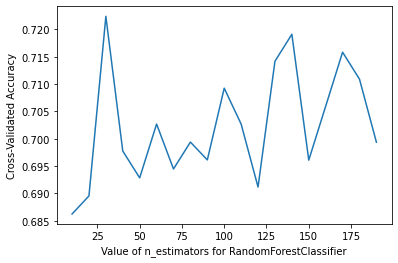

In [261]:
from sklearn.ensemble import RandomForestClassifier

estimators_range = range(10,200, 10)
estimators_scores = {}

for e in estimators_range:
    model = RandomForestClassifier(n_estimators=e)
    scores = cross_val_score(model, qbs_attributes, results, cv=5, scoring='accuracy')
    estimators_scores[e] = scores.mean()

plt.plot(list(estimators_scores.keys()), list(estimators_scores.values()))
plt.xlabel('Value of n_estimators for RandomForestClassifier')
plt.ylabel('Cross-Validated Accuracy')

Agora vamos procurar qual foi o número de estimadores que gerou a melhor acurácia.

In [262]:
best_estimators = 1
best_accuracy = 0

for index, accuracy in estimators_scores.items():
  if best_accuracy < accuracy:
    best_estimators = index
    best_accuracy = accuracy

print("A melhor acurácia (", best_accuracy*100, "%) foi encontrada com n_estimators =", best_estimators)

A melhor acurácia ( 72.23953393849072 %) foi encontrada com n_estimators = 30


## Consideraçoes finais


A melhor acurácia encontrada foi de 73% com o modelo classificador MLP.


Talvez a quantidade baixa de dados (609 linhas) tenha impactado no quão bom o modelo se tornou.
